### Basic Information

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import h3
import folium
import branca.colormap as cm

In [2]:
# df_offers = pd.read_csv('./datasets/data_offers.csv')
df = pd.read_csv('./datasets/data_orders.csv')
# df = df_orders.merge(df_offers, how = 'left', on='order_gk')

In [3]:
df.shape[0]

10716

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10716 entries, 0 to 10715
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_datetime                 10716 non-null  object 
 1   origin_longitude               10716 non-null  float64
 2   origin_latitude                10716 non-null  float64
 3   m_order_eta                    2814 non-null   float64
 4   order_gk                       10716 non-null  int64  
 5   order_status_key               10716 non-null  int64  
 6   is_driver_assigned_key         10716 non-null  int64  
 7   cancellations_time_in_seconds  7307 non-null   float64
dtypes: float64(4), int64(3), object(1)
memory usage: 669.9+ KB


 ### 1. Build up distribution of orders according to reasons for failure: cancellations before and after driver assignment, and reasons for order rejection. Analyse the resulting plot. Which category has the highest number of orders?

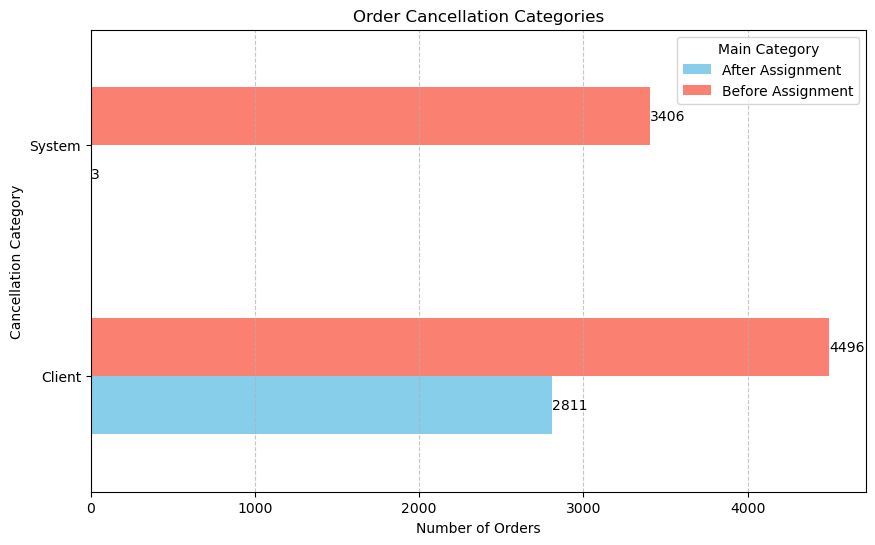

cancellation_category
Client - Before Assignment    4496
System - Before Assignment    3406
Client - After Assignment     2811
System - After Assignment        3
Name: count, dtype: int64

In [5]:
# 应用原始逻辑设置cancellation_category
df.loc[(df['order_status_key'] == 4) & (df['is_driver_assigned_key'] == 0), 'cancellation_category'] = 'Client - Before Assignment'
df.loc[(df['order_status_key'] == 4) & (df['is_driver_assigned_key'] == 1), 'cancellation_category'] = 'Client - After Assignment'
df.loc[(df['order_status_key'] == 9) & (df['is_driver_assigned_key'] == 0), 'cancellation_category'] = 'System - Before Assignment'
df.loc[(df['order_status_key'] == 9) & (df['is_driver_assigned_key'] == 1), 'cancellation_category'] = 'System - After Assignment'

# 创建主分类和子分类
df['Sub Category'] = df['cancellation_category'].apply(lambda x: x.split(' - ')[0] if ' - ' in x else 'Other')
df['Main Category'] = df['cancellation_category'].apply(lambda x: x.split(' - ')[1] if ' - ' in x else 'Other')

# 计算每个子分类的数量
sub_cat_counts = df.groupby(['Sub Category', 'Main Category']).size().unstack(fill_value=0)

# 绘制条形图
fig, ax = plt.subplots(figsize=(10,6))
sub_cat_counts.plot(kind='barh', stacked=False, color=['skyblue', 'salmon'], ax=ax)

# 设置图例
ax.legend(title='Main Category')

# 设置标题和坐标轴标签
ax.set_title('Order Cancellation Categories')
ax.set_xlabel('Number of Orders')
ax.set_ylabel('Cancellation Category')

# 添加网格线
ax.grid(axis='x', linestyle='--', alpha=0.7)

# 循环访问每个条形，并在每个条形上方添加计数
for bar in ax.patches:
    ax.text(bar.get_width(), bar.get_y() + bar.get_height() / 2,
            '{:.0f}'.format(bar.get_width()),
            va='center', ha='left')

cancellation_counts = df['cancellation_category'].value_counts()

plt.show()
cancellation_counts

### 2. Plot the distribution of failed orders by hours. Is there a trend that certain hours have an abnormally high proportion of one category or another? What hours are the biggest fails? How can this be explained?

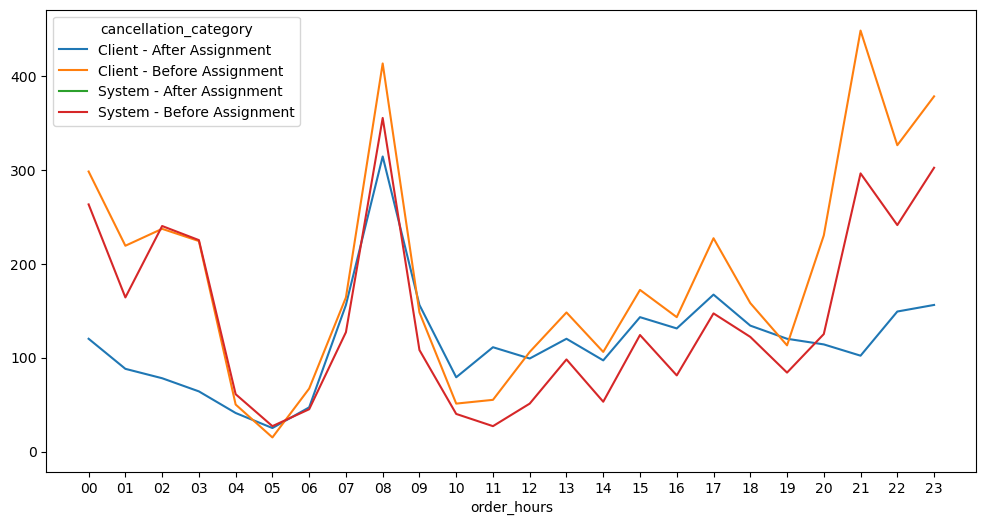

In [6]:
df['order_hours'] = df['order_datetime'].str.split(':').apply(lambda split: split[0])
grp = df.groupby(by=['order_hours', 'cancellation_category'])['order_gk'].count()
pivot = grp.reset_index().pivot(index="order_hours", columns=["cancellation_category"], values="order_gk")
pivot.plot(figsize = (12, 6), xticks = range(0, 24))
plt.show()

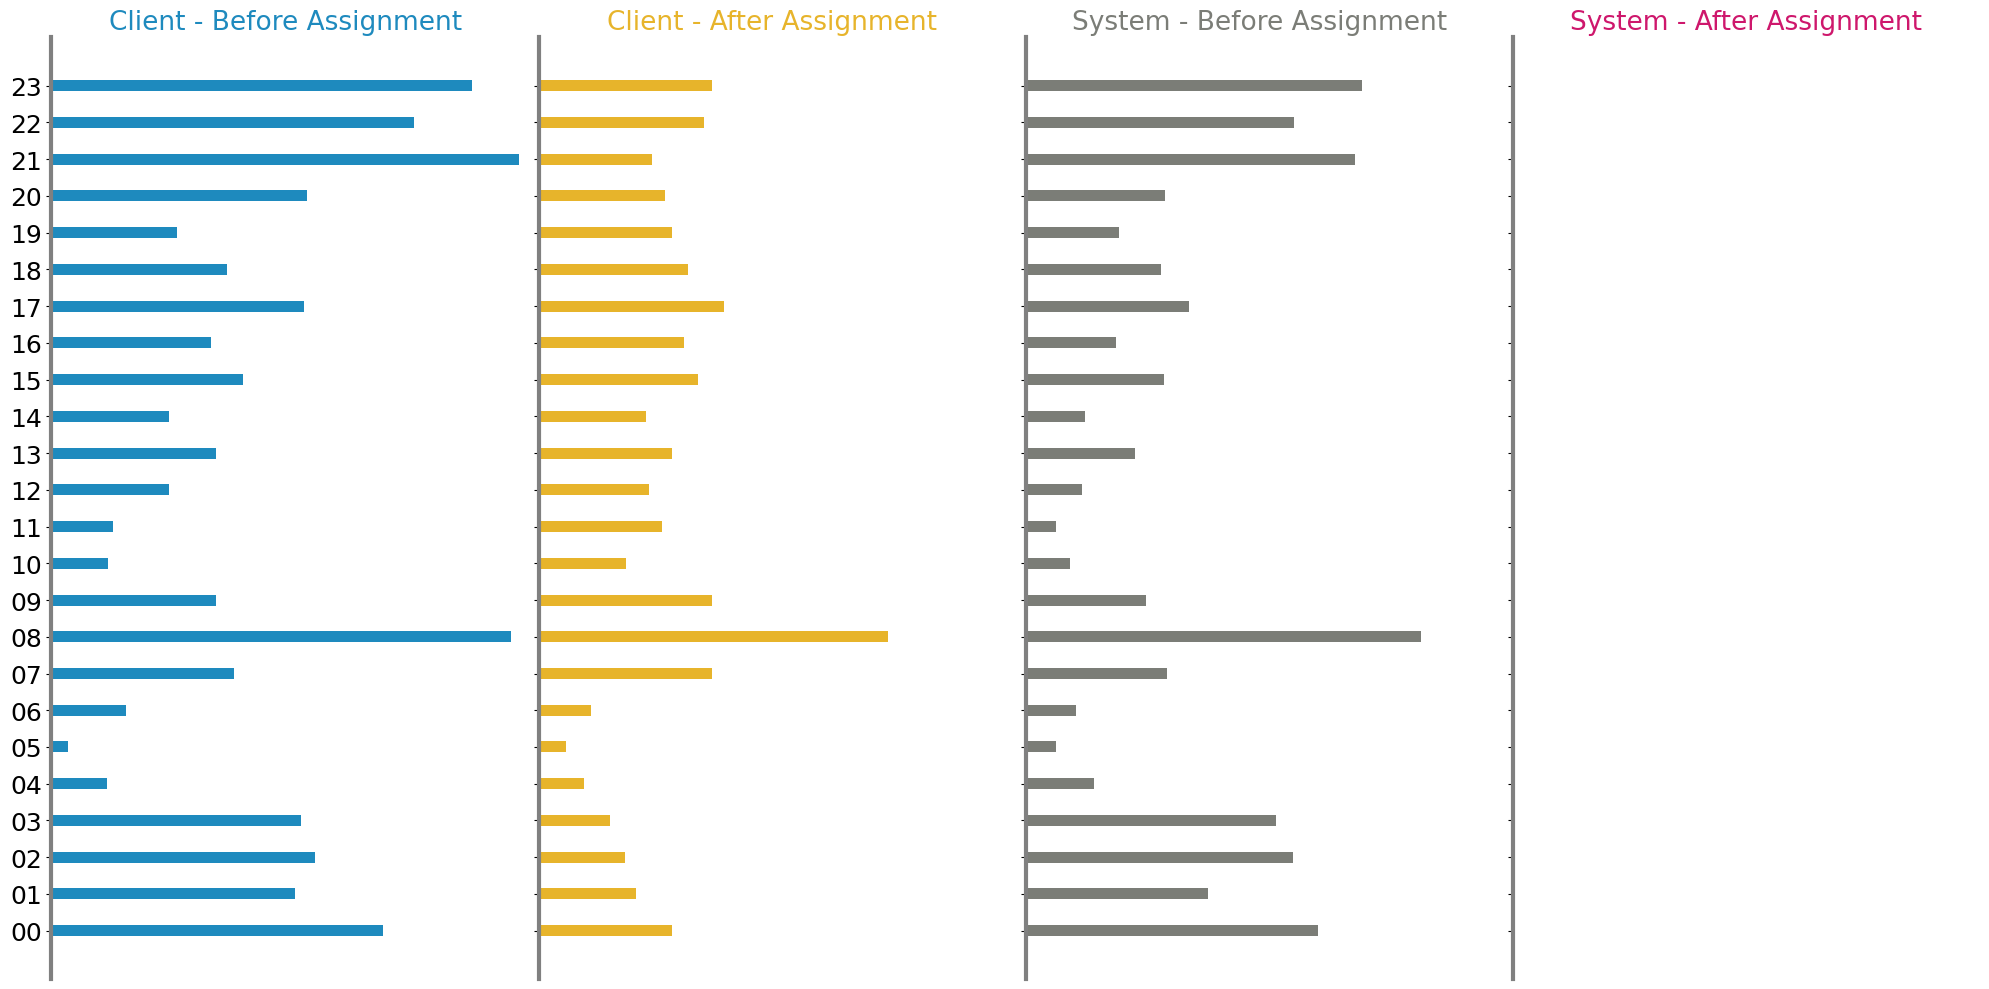

In [10]:
categories = ['Client - Before Assignment', 'Client - After Assignment', 'System - Before Assignment', 'System - After Assignment']
num_categories = len(categories)
fig, axs = plt.subplots(1, num_categories, figsize = (20,10), sharey=True)
colors = ['#1e8abe','#e7b42b','#7b7d77','#ce176c']
height = 0.3
for i, ax in enumerate(axs):
    value = df[df['cancellation_category'] == categories[i]].groupby(by=['order_hours'])['order_gk'].count()
    ax.barh(value.index, value.values, color=colors[i], height = height)
    ax.set_title(categories[i], fontsize=19, color=colors[i])
    ax.set_xlim(0,420)
    ax.set_xticks([])
    ax.tick_params(axis='y', labelsize=18)
    # 去除边框线
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_color('gray')  # 将左边的边框线设为灰色
    ax.spines['left'].set_linewidth(3)  # 将左边边框线的宽度设为2
plt.tight_layout()
plt.show()

* Peak Fail Times: 
It appears that there's a significant peak around 08:00 for all categories, which might indicate a systemic issue at this time, such as higher demand that cannot be met or perhaps a scheduled system maintenance or update that's poorly timed.

* Client vs. System: 
Client-initiated cancellations, especially before assignment, remain relatively higher than system-initiated cancellations throughout the day, which suggests client actions might be a larger factor in failed orders than system issues.

* Before vs. After Assignment:
For both the client and system categories, cancellations after assignment are generally lower than those before assignment, indicating there might be issues related to the ordering process rather than the ordering fulfillment process itself.

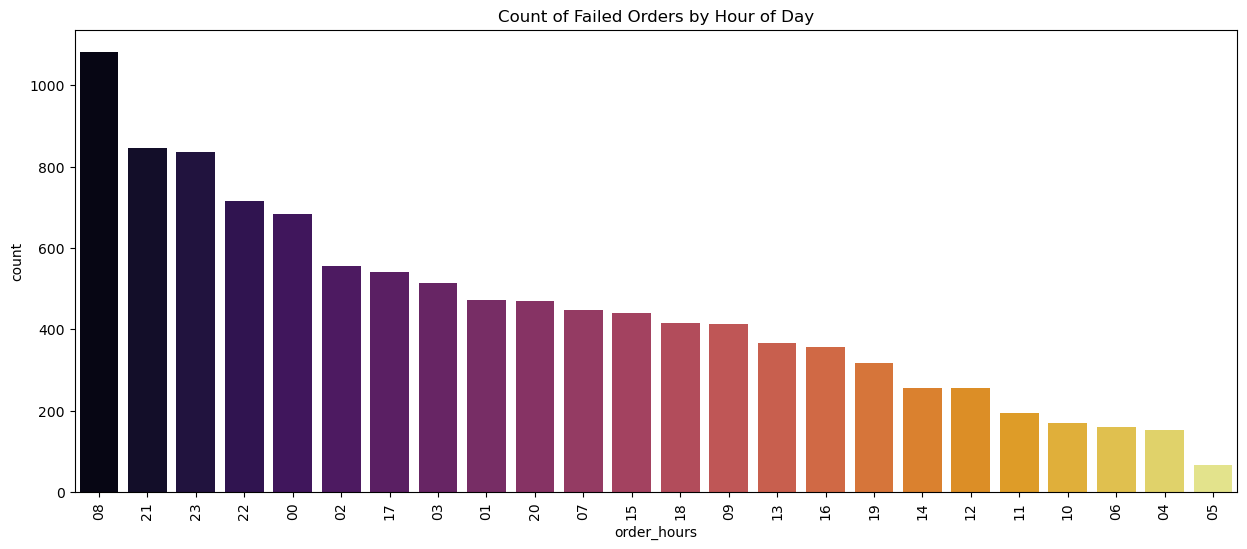

In [11]:
plt.subplots(figsize=(15,6))
sns.countplot(x=df['order_hours'], palette='inferno', order=df['order_hours'].value_counts().index)
plt.xticks(rotation=90)
plt.title('Count of Failed Orders by Hour of Day')
plt.show()

* Biggest Fail Hours: 
The biggest number of order failures occur during the evening hours, specifically at 8 PM (20), followed by 9 PM (21) and then 11 PM (23).

* Potential Reasons:
A large number of commuters are requesting rides simultaneously, overwhelming the system and leading to failed orders.
Most Gett drivers may have clocked out for the day, leading to a scarcity of available cars. This mismatch between supply and demand likely contributes to the increase in failed orders.

### 3. Plot the average time to cancellation with and without driver, by the hour. If there are any outliers in the data, it would be better to remove them. Can we draw any conclusions from this plot?

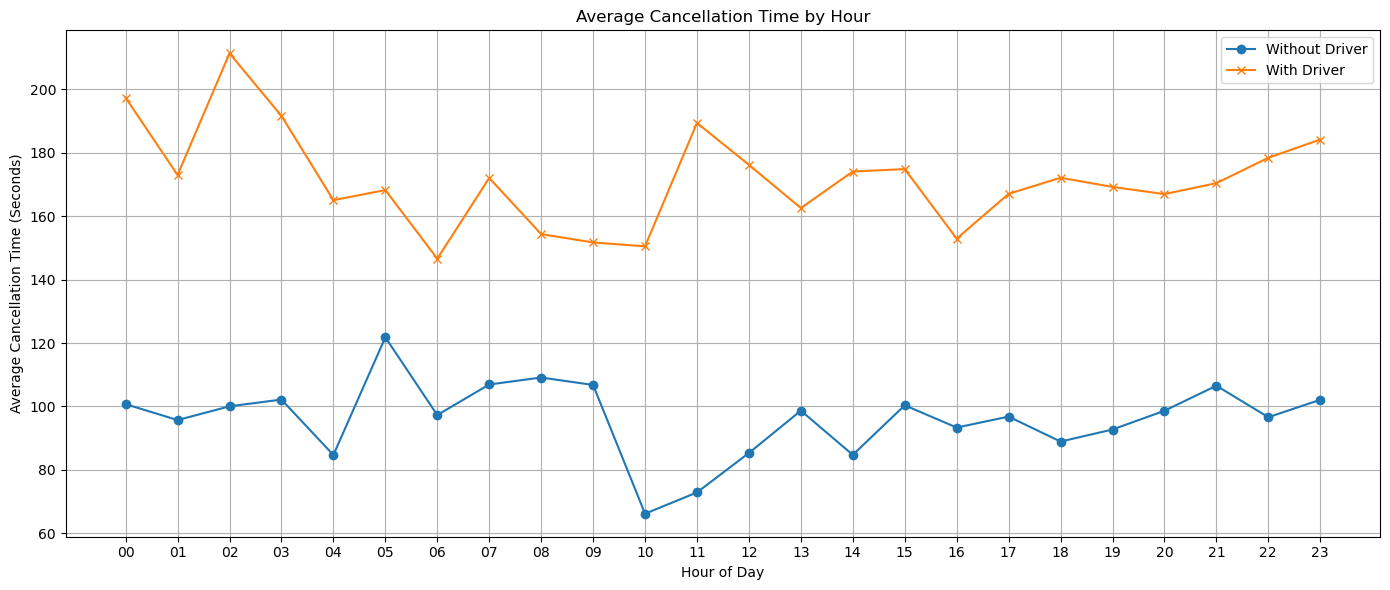

In [12]:
data_no_driver = df[df['is_driver_assigned_key'] == 0]
data_with_driver = df[df['is_driver_assigned_key'] == 1]

# 修改函数来计算平均取消时间并返回异常值的数量
def calculate_avg_time_and_outliers(data, time_column):
    # 计算四分位数
    Q1 = data[time_column].quantile(0.25)
    Q3 = data[time_column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # 移除异常值并计算平均取消时间
    data_filtered = data[(data[time_column] >= lower_bound) & (data[time_column] <= upper_bound)]
    avg_time_by_hour = data_filtered.groupby('order_hours')[time_column].mean()
    
    return avg_time_by_hour

# 计算无司机时的平均取消时间
avg_time_no_driver = calculate_avg_time_and_outliers(data_no_driver, 'cancellations_time_in_seconds')

# 计算有司机时的平均取消时间
avg_time_with_driver = calculate_avg_time_and_outliers(data_with_driver, 'cancellations_time_in_seconds')

plt.figure(figsize=(14, 6))
plt.plot(avg_time_no_driver.index, avg_time_no_driver.values, label='Without Driver', marker='o')
plt.plot(avg_time_with_driver.index, avg_time_with_driver.values, label='With Driver', marker='x')

plt.title('Average Cancellation Time by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Average Cancellation Time (Seconds)')
plt.legend()
plt.grid(True)
plt.xticks(range(24))
plt.tight_layout()
plt.show()

From the graph, we can see that the average time to cancellation is generally higher for orders with a driver compared to those without a driver. This suggests that drivers may be contributing to longer cancellation times. 

The peak occurs at 2 A.M. At this time there are a lot of client cancellations, so a logical explanation would be that clients have waited too long for the driver.

### 4. Plot the distribution of average ETA by hours. How can this plot be explained?

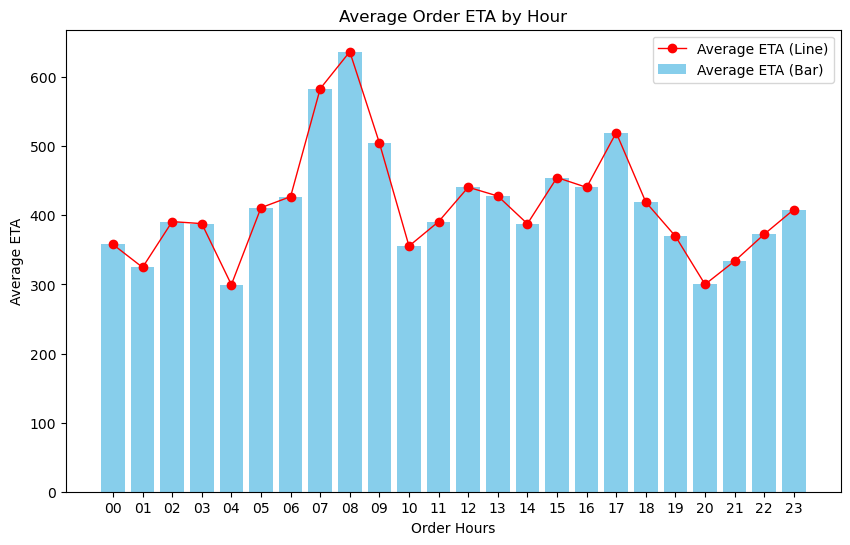

In [22]:
grouped = df.groupby('order_hours')['m_order_eta'].mean().reset_index()

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(grouped['order_hours'], grouped['m_order_eta'], color='skyblue', label='Average ETA (Bar)')
ax.plot(grouped['order_hours'], grouped['m_order_eta'], color='red', marker='o', linewidth=1, label='Average ETA (Line)')

ax.set_title('Average Order ETA by Hour')
ax.set_xlabel('Order Hours')
ax.set_ylabel('Average ETA')

ax.legend()
plt.show()

The line very closely matches the count of failed orders per hour, indicating that the number of failed orders increases as the average waiting time of the client increases.

### 5. BONUS Hexagons. Using the h3 and folium packages, calculate how many sizes 8 hexes contain 80% of all orders from the original data sets and visualize the hexes, colouring them by the number of fails on the map.

In [14]:
def lat_lng_to_h3(lat, lng, hex_size=8):
    return h3.geo_to_h3(lat, lng, hex_size)

In [15]:
df['hex'] = df.apply(
    lambda x: lat_lng_to_h3(x['origin_latitude'], x['origin_longitude']), axis=1)
order_counts_per_hex = df['hex'].value_counts()

In [16]:
median_latitude = df['origin_latitude'].median()
median_longitude = df['origin_longitude'].median()
order_counts_per_hex = df['hex'].value_counts()

In [17]:
quantiles = order_counts_per_hex.quantile([0.1, 0.2, 0.4, 0.6, 0.8, 1])
min_count = order_counts_per_hex.min()
max_count = order_counts_per_hex.max()

# Create a linear color scale
color_scale = cm.LinearColormap(
    colors=['#B7B7EB', 'steelblue', '#8CBF87', '#CB9475', '#8D2F25'],
    vmin=min_count,
    vmax=max_count
)

# Make sure to normalize the scale if you have a wide range of values
color_scale = color_scale.to_step(n=5)
color_scale.caption = 'Number of Failed Orders'

# Now create the Folium map and add the hexagons
map_with_hexes = folium.Map(location=[median_latitude, median_longitude], zoom_start=12)

for hex_id, count in order_counts_per_hex.items():
    hex_boundary = h3.h3_to_geo_boundary(hex_id, geo_json=True)
    hex_boundary = [(coords[1], coords[0]) for coords in hex_boundary]
    
    # Apply the color scale to each count value
    hex_color = color_scale(count)
    
    folium.Polygon(
        locations=hex_boundary,
        color=hex_color,  # The outline color of the hexagon
        fill_color=hex_color,  # The fill color of the hexagon
        fill_opacity=0.6,  # The fill opacity of the hexagon
        weight=1,  # The line weight of the hexagon
    ).add_to(map_with_hexes)

# Add the color scale to the map
color_scale.add_to(map_with_hexes)

# Display the map
map_with_hexes

In [18]:
map_with_hexes.save('Map.html')

The visualization illustrates that Reading exhibits a notably elevated incidence of ride service disruptions compared to the average. It is crucial to ascertain the reasons behind the challenges faced by customers in this location, which may stem from inadequate vehicle availability during peak hours or undisclosed localized issues that have yet to come to our attention. The subsequent course of action entails meticulously examining the specific timeframes during which these problems manifest and engaging with both our drivers and customers in the region to garner their firsthand insights. Through the accrual of comprehensive data, we will accurately identify the underlying causes and devise a strategy to enhance our service provision in Reading.